In [3]:
from IPython.display import Image
import itertools

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import autograd.numpy as np
from autograd import grad

%matplotlib inline

# Stein Variational Gradient Descent
### by Qiang Liu, Dilin Wang (https://arxiv.org/abs/1608.04471)

Particles explore the posterior according to the following iterative algorithm
$$ \theta_{i}^{l+1} \leftarrow \theta_{i}^{l} + \epsilon \boldsymbol{\hat \phi}(\theta_{i}^{l}) \text{  where  } \boldsymbol{\hat \phi}(\theta_{i}^{l}) = \frac{1}{n} \sum_{j=1}^{n} k(\theta_{j}^{l}, \theta) \nabla_{\theta_{j}^{l}} \log p(\theta_{j}^{l}) + \nabla_{\theta_{j}^{l}} k(\theta_{j}^{l}, \theta)$$
where $k$ is a valid kernel and $\epsilon$ is a step-size.  The operator $\boldsymbol{\hat \phi}(\theta_{i}^{l})$ is implemented below:

### Kernels for $\mathbb{R}^{d}$

In [77]:
# Probability Product Kernel
def prob_prod(z1_mu, z1_log_sigma, z2_mu, z2_log_sigma, scale=3.):
    
    z1_sigma = np.exp(z1_log_sigma)
    z2_sigma = np.exp(z2_log_sigma)

    rho = 1./scale
    sigma_star = 1./z1_sigma + 1./z2_sigma
    mu_star = z1_mu/z1_sigma + z2_mu/z2_sigma
    norm = (2*3.14)**((1.-2*rho)*(1./2.)) * rho**(-.5) * sigma_star**.5 * z1_sigma**(-rho/2.) * z2_sigma**(-rho/2.)

    return norm * np.exp( -rho/2. * ((z1_mu**2)/z1_sigma + (z2_mu**2)/z2_sigma - (mu_star**2)/sigma_star ) )

def prob_prod2(z1_log_sigma, z1_mu, z2_mu, z2_log_sigma, scale=3.):
    
    z1_sigma = np.exp(z1_log_sigma)
    z2_sigma = np.exp(z2_log_sigma)

    rho = 1./scale
    sigma_star = 1./z1_sigma + 1./z2_sigma
    mu_star = z1_mu/z1_sigma + z2_mu/z2_sigma
    norm = (2*3.14)**((1.-2*rho)*(1./2.)) * rho**(-.5) * sigma_star**.5 * z1_sigma**(-rho/2.) * z2_sigma**(-rho/2.)

    return norm * np.exp( -rho/2. * ((z1_mu**2)/z1_sigma + (z2_mu**2)/z2_sigma - (mu_star**2)/sigma_star ) )


# Radial Basis Function (Heat Kernel)
def rbf(x1, x2, params={'lengthScale': 5.}):
    return np.exp((-.5/params['lengthScale']) * np.sum((x1-x2)**2))

## Models

### Gaussian Mixture Model

[{'mu': 1.9520301325164118, 'log_sigma': 0.82755193589675902}, {'mu': 6.1449301543655235, 'log_sigma': 0.86748780449256468}, {'mu': 1.241864108156552, 'log_sigma': 1.4445233015394481}, {'mu': -3.7959579091146312, 'log_sigma': 0.11500893878551002}]


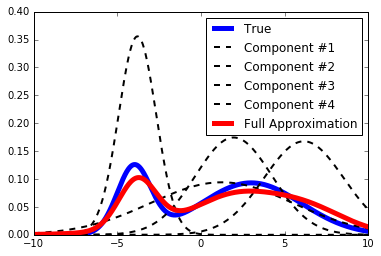

In [78]:
# Model
def gaussPdf(x, params):
    return (1./np.sqrt(2*np.pi*params['sigma']**2)) * np.exp((-.5/params['sigma']**2) * np.sum((x-params['mu'])**2))

def gaussEntropy(log_sigma):
    return .5 * (np.log(2*np.pi*np.e) + 2.*log_sigma)

def logGaussMixPDF(x, params):
    return np.log(params['pi'][0] * gaussPdf(x, {'mu':params['mu'][0], 'sigma':params['sigma'][0]}) \
            + params['pi'][1] * gaussPdf(x, {'mu':params['mu'][1], 'sigma':params['sigma'][1]}))

# get model grad wrt sample
logModel = logGaussMixPDF
dLogModel = grad(logModel)

# get entropy grad wrt log sigma
dEntropy_dLogSigma = grad(gaussEntropy)

# kernel
kernel = {'f': prob_prod}
kernel['df_mu'] = grad(kernel['f'])
kernel['df_lsig'] = grad(prob_prod2)

params = {
    'mu': [-4,3],
    'sigma': [1, 3],
    'pi': [.3, .7]
}

# initial distribution
q0 = np.random.normal

### generate samples
n = 4
psi = []
for sampleIdx in xrange(n):
    psi.append( {'mu':q0(), 'log_sigma':0.} )
    
    
# Modified Stein Op
def steinOp(vi_params, idx, dLogModel, params, dEntropy, kernel, kernelParams=None):
    
    returnVal_mu = 0.
    returnVal_logSigma = 0.
    
    K = len(vi_params)
    for k in xrange(K):
        
        epsilon = np.random.normal()
        x_sample = vi_params[k]['mu'] + epsilon * np.exp(vi_params[k]['log_sigma'])
        
        grad_mu = dLogModel(x_sample, params) * 1. 
        
        grad_log_sigma = dLogModel(x_sample, params) * epsilon * np.exp(vi_params[k]['log_sigma'])
        grad_log_sigma += dEntropy(vi_params[k]['log_sigma'])
        
        returnVal_mu += kernel['f'](vi_params[k]['mu'], vi_params[k]['log_sigma'], vi_params[idx]['mu'], vi_params[idx]['log_sigma']) * grad_mu 
        returnVal_mu += kernel['df_mu'](vi_params[k]['mu'], vi_params[k]['log_sigma'], vi_params[idx]['mu'], vi_params[idx]['log_sigma'])
        
        returnVal_logSigma += kernel['f'](vi_params[k]['mu'], vi_params[k]['log_sigma'], vi_params[idx]['mu'], vi_params[idx]['log_sigma']) * grad_log_sigma
        returnVal_logSigma += kernel['df_lsig'](vi_params[k]['log_sigma'], vi_params[k]['mu'], vi_params[idx]['mu'], vi_params[idx]['log_sigma'])

    return (1./K * returnVal_mu, 1./K * returnVal_logSigma)
    
    
maxEpochs = 750
lr_mu = .1
lr_sig = .05
for epochIdx in xrange(maxEpochs):
    for idx in xrange(n):
        update = steinOp(psi, idx, dLogModel, params, dEntropy_dLogSigma, kernel)
        psi[idx]['mu'] += lr_mu * update[0]
        psi[idx]['log_sigma'] += lr_sig * update[1]
        
print psi
        
plt.figure()

# plot true distributions
x_true = np.linspace(-10, 10, 1000)
probs_true = [np.exp(logModel(z, params)) for z in x_true]
plt.plot(x_true, probs_true, 'b-', linewidth=5, label="True")

# plot latent
colors = ['r','g','y','m']
probs_approx = []
for k in xrange(n):
    probs_approx.append([gaussPdf(z, {'mu':psi[k]['mu'], 'sigma':np.exp(psi[k]['log_sigma'])}) for z in x_true]) 
    plt.plot(x_true, probs_approx[-1], '--k', linewidth=2, label="Component #%d" %(k+1))
    
full_approx = np.zeros(x_true.shape[0])
for k in xrange(n):
    full_approx += 1./n * np.array(probs_approx[k])
plt.plot(x_true, full_approx, '-r', linewidth=5, label="Full Approximation")
    
plt.xlim([-10,10])
plt.ylim([0,.4])
plt.legend()
plt.show()